[INFO] Reading GeoTIFF: example_mod.tif
[INFO] Raw DN range: 14.48 – 258.25
[INFO] After log stretch → uint8 range: 0 – 255
[INFO] Saved temporary image for prediction: tmp_for_predict.png
ONNX model loaded: FY4A
[INFO] Pred mask shape: (801, 801), unique values: [  0 255]
[INFO] Detected internal-wave pixels: 1073
[INFO] Saved locations TXT → outputs/example/iw_locations.txt


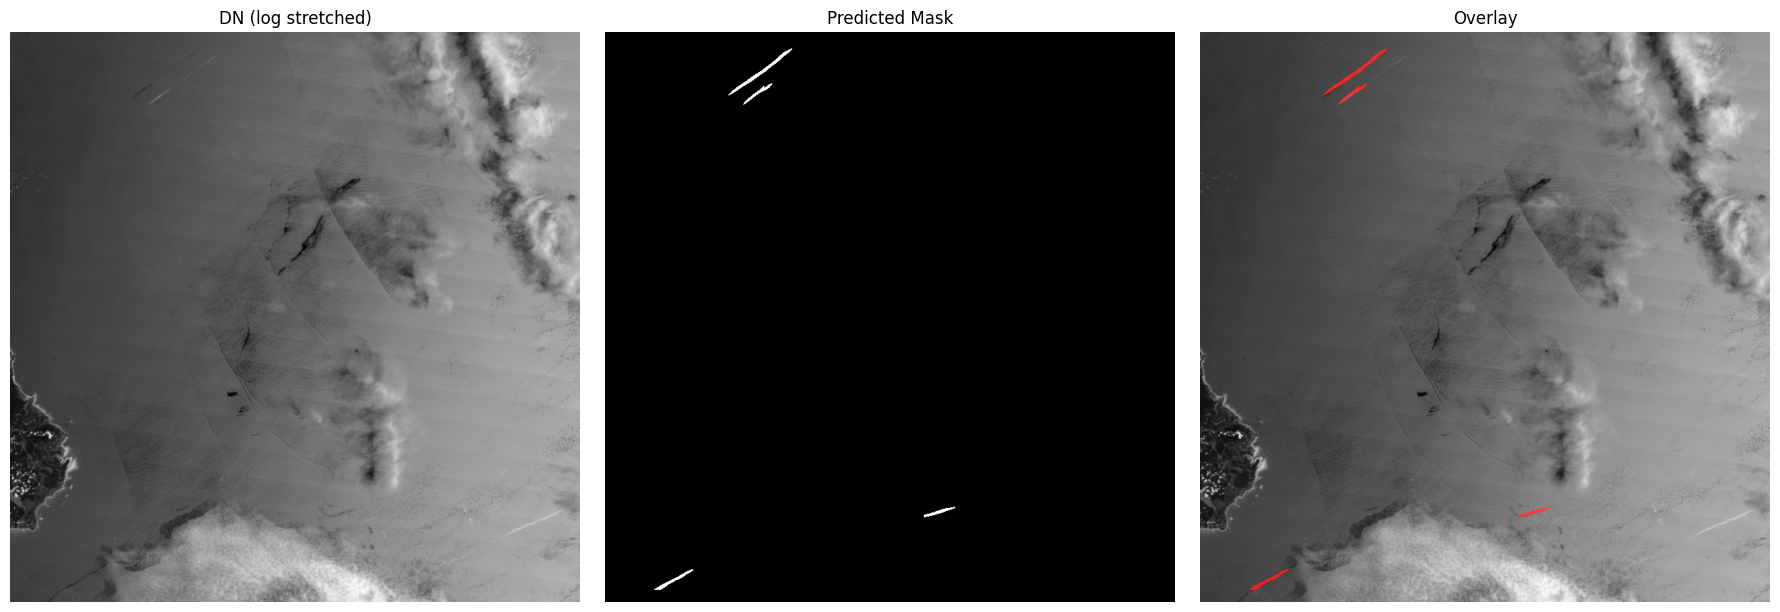

In [2]:
import os
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from predictor import ModelPredictor

# 1. 读取 GeoTIFF 并做对数拉伸
tiff_path = "example_mod.tif"
print(f"[INFO] Reading GeoTIFF: {tiff_path}")
ds = rxr.open_rasterio(tiff_path, masked=True)
dn = np.array(ds[0].data)
print(f"[INFO] Raw DN range: {dn.min():.2f} – {dn.max():.2f}")

# 对 DN 做 log1p 压缩（避免极端大值主导）
dn_log = np.log1p(dn)
dn_log_min, dn_log_max = dn_log.min(), dn_log.max()
dn_norm = (dn_log - dn_log_min) / (dn_log_max - dn_log_min)
dn_uint8 = (dn_norm * 255).astype(np.uint8)
print(f"[INFO] After log stretch → uint8 range: {dn_uint8.min()} – {dn_uint8.max()}")

# 获取经纬度网格
x = np.array(ds['x'])
y = np.array(ds['y'])
lon, lat = np.meshgrid(x, y)

# 2. 用伪 RGB 调用模型预测
rgb = np.stack([dn_uint8]*3, axis=-1)
tmp_path = "tmp_for_predict.png"
Image.fromarray(rgb).save(tmp_path)
print(f"[INFO] Saved temporary image for prediction: {tmp_path}")

predictor = ModelPredictor("FY4A", remove_small_noises=True)
pred_mask = predictor.predict(input_image_path=tmp_path)
# os.remove(tmp_path)
print(f"[INFO] Pred mask shape: {pred_mask.shape}, unique values: {np.unique(pred_mask)}")

# 3. 提取“内波”像素对应的经纬度
mask_bool = pred_mask > 128
count = mask_bool.sum()
print(f"[INFO] Detected internal-wave pixels: {count}")

rows, cols = np.where(mask_bool)
pts_lon = lon[rows, cols]
pts_lat = lat[rows, cols]

# 4. 导出经纬度到 TXT
out_dir = os.path.join("outputs", "example")
os.makedirs(out_dir, exist_ok=True)
txt_file = os.path.join(out_dir, "iw_locations.txt")
with open(txt_file, "w") as f:
    for lo, la in zip(pts_lon, pts_lat):
        f.write(f"{lo:.6f},{la:.6f}\n")
print(f"[INFO] Saved locations TXT → {txt_file}")

# 5. 可视化对比：log 图 / 预测掩码 / 叠加
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(dn_uint8, cmap='gray', origin='upper')
ax1.set_title("DN (log stretched)")
ax1.axis('off')

ax2.imshow(pred_mask, cmap='gray', origin='upper')
ax2.set_title("Predicted Mask")
ax2.axis('off')

# 红色叠加
overlay = np.dstack([dn_uint8]*3)
overlay[mask_bool, 0] = 255
overlay[mask_bool, 1:] = overlay[mask_bool, 1:] // 2

ax3.imshow(overlay, origin='upper')
ax3.set_title("Overlay")
ax3.axis('off')

plt.tight_layout()
plt.show()
